# Noise2Void - 2D Example

In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [2]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [4]:
base_dir = '/Volumes/USER_data/Dominik/CECELIA_BACKUP/CV5iNI/ANALYSIS/'
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'fmjlDg')

In [5]:
# Tom
uids = ['ocGpqr', 'FSotUw', 'vJV9by', 'tM949V', '50ymIS', '2DWW5C', '6J6z8t', 'nuL8W0', '5EZW5E', 'WzDKfW', 'ZLATW0', 'Qphi2J', 'MWQBVD', 'YBq5rm', '588Dj0', 'IzjXlv', 'QdjG8p', 'CfTwJD', 'bqdS4D', 'eXhH0u', 'qcwblF', 'I32uRk', '5OfZTY', 'yJyPDn', 'btZFiO', 'zRyuzO', 'EbYjEw', 'eAX4fZ', 'RpFBeG', '0wlkTG', 'TVf7C7', '0WkJ2n', 'pR8OoS', 'D3rG8h', 'wVL31E', 'kI45Yr', 'EFSIfI', 'KuY1Nm', 'ryKCBh', 'IcNmah', 'qvhTEJ', '8yr0h5', '1TqO7r', 'xIkEjm', 'gf6vXf', 'v1De25', 'x8sHW6', 'HXO9hG', 'SF82TQ', '0OvjSI', 'KQZxwr', 'm2n2Ft', 'PGCD8S', 'AdYO7L', 'SYXMth', '7dBggN', 'z6Jti0', 'XnVCIm', 'vjENx0', 'WFpe38', 'OWodvg', '0nNQWs', 'QrRXBk', 'GSUOLg', 'qC8o1T', '27p88D', 'G49ZZx', '23BeFx', 'g0jRwo', 'E14r6I']

In [6]:
# XCR1
uids = ['WvmInm', '43Wrm6', 'zGJ6Zx', 'r0lLnq', 'irQcyT', 'xrpULx', 'NJvsNY', 'RgC7Wn', 'F5JvHp', '0XIgdc', 'VsY1bp', '5uVnh2', '3nNcPG', 'AZ1f7k', 'FcbjWa', '7oh2II', 'xAivFa', 'DyLaDq', 'ZAWNaT', 'HhKbUR', 'COnsaW', 'HTWRuh', '2JxLGc', 'YuMg8j', 'pnjMea', 'r30OyS', 'mskvXN', 'FrimIN', 'stm1J4', '4Ky14J', 'Ti2xhq', 'ajiVG3', 'z43ZmK', 'a5N98R', 'EWyt7S', 'uxXWQW', 'Rj5rxu', 'zsROWp', 'NSupPO', 'encBlg', 'KDVAxS', 'H9uFRN', 'lFuBwE', '9GaL76', 'ApHcZ5', 'jiI7v6', 'kStCa2', '8M6efc', 'Tvr1BS', '7SFBI6', 'PuViWT', 'TqPA9L', '5nTQdi', 'EMaQj2', 'DSRdqh', 'yz1yhZ', '0niKqI', 'rDKeGd', 'uhf9Xx', '5mwG5V', '8uHyK7', 'zBZm20', 'JhdPZU', 'RufKxs', 'FHIGav', 'vkAjt0', 'otPUph', 'tZpWza', 'LRttqF', '7LFxXL']

In [7]:
import py.zarr_utils as zarr_utils
import skimage.filters

# get zarr
# imgs = {i: zarr_utils.open_as_zarr(os.path.join(base_dir, '0', i, 'ccidImage.zarr')) for i in uids}
imgs = [zarr_utils.open_as_zarr(os.path.join(base_dir, '0', i, 'ccidImage.zarr')) for i in uids]

# get arrays
# imgs = {i: np.squeeze(np.array(zarr_utils.fortify(x[0]))) for i, x in imgs.items()}
imgs = [np.squeeze(np.array(zarr_utils.fortify(x[0]))) for x in imgs]

<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<

In [8]:
# add gaussian
# imgs = [skimage.filters.gaussian(x, sigma = 1) for x in imgs]

# add time
imgs = [np.expand_dims(x, axis = 0) for x in imgs]

# add RGB
imgs = [np.expand_dims(x, axis = len(imgs[0].shape)) for x in imgs]

In [9]:
(len(imgs), imgs[0].shape)

(70, (1, 8, 512, 512, 1))

In [10]:
# Here we extract patches for training and validation.
# Try 3D?
patch_shape = (4, 64, 64)
#patch_shape = (64, 128, 128)

patches = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape, shuffle=True)

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
split_val = round(len(patches) * 0.8)

X = patches[:split_val]
X_val = patches[split_val:]

train_steps_per_epoch = int(X.shape[0]/64)
#train_steps_per_epoch = int(X.shape[0]/16)

#train_epochs = 100
train_epochs = 20

(len(X), len(X_val))

Generated patches: (1024, 4, 64, 64, 1)


(819, 205)

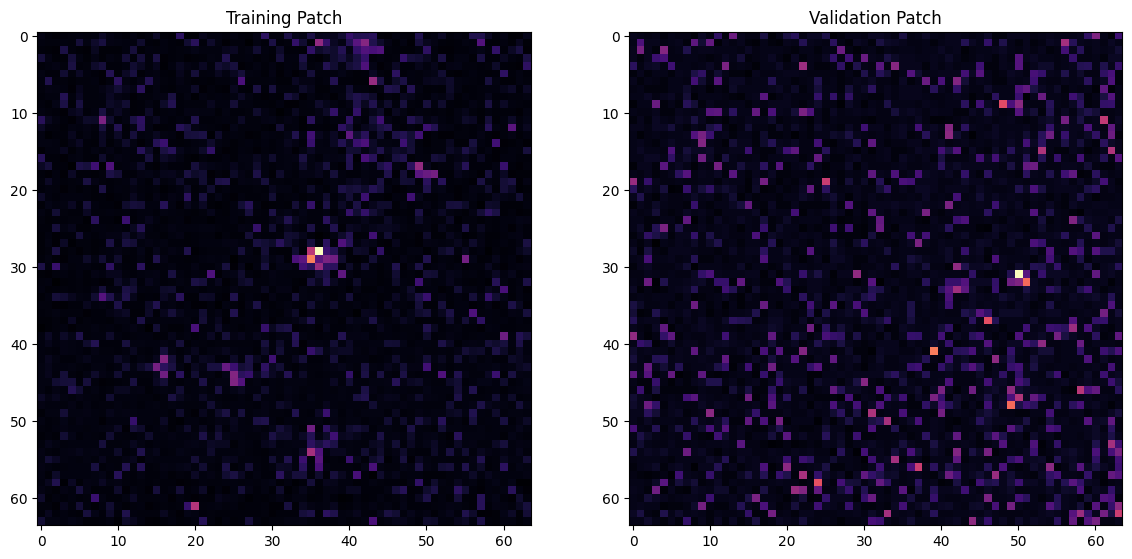

In [11]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(np.max(X[0,...,0], axis = 0),cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(np.max(X_val[0,...,0], axis = 0),cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [12]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=train_steps_per_epoch,train_epochs=train_epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['5.360399183336195'],
 'stds': ['8.820820760502713'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 12,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (4, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [13]:
# a name used to identify the model
# model_name = 'n2v_3P_ubiTom'
model_name = 'n2v_3P_XCR1'

# the base directory in which our model will live
basedir = '/Users/Dominik/Downloads/n2v'

# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

## Training

In [14]:
history = model.train(X, X_val)

32 blind-spots will be generated per training patch of size (4, 64, 64).


Preparing validation data: 100%|████████████████████████████████████████████████| 205/205 [00:00<00:00, 2224.37it/s]

Epoch 1/20


12/12 [==============================] - 26s 2s/step - loss: 2.2361 - n2v_mse: 2.2361 - n2v_abs: 1.0276 - val_loss: 1.1049 - val_n2v_mse: 1.1050 - val_n2v_abs: 0.7690 - lr: 4.0000e-04
Epoch 2/20
12/12 [==============================] - 20s 2s/step - loss: 1.0723 - n2v_mse: 1.0723 - n2v_abs: 0.7113 - val_loss: 1.0506 - val_n2v_mse: 1.0511 - val_n2v_abs: 0.7342 - lr: 4.0000e-04
Epoch 3/20
12/12 [==============================] - 21s 2s/step - loss: 0.4697 - n2v_mse: 0.4697 - n2v_abs: 0.5164 - val_loss: 0.9919 - val_n2v_mse: 0.9865 - val_n2v_abs: 0.6988 - lr: 4.0000e-04
Epoch 4/20
12/12 [==============================] - 21s 2s/step - loss: 0.5275 - n2v_mse: 0.5275 - n2v_abs: 0.5117 - val_loss: 0.9581 - val_n2v_mse: 0.9503 - val_n2v_abs: 0.6716 - lr: 4.0000e-04
Epoch 5/20
12/12 [==============================] - 21s 2s/step - loss: 1.6087 - n2v_mse: 1.6087 - n2v_abs: 0.7807 - val_loss: 0.9756 - val_n2v_mse: 0.9667 - val_n2v_abs: 0.6732 - lr: 4.0000e-04
Epoch 6/20
12/12 [==================

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


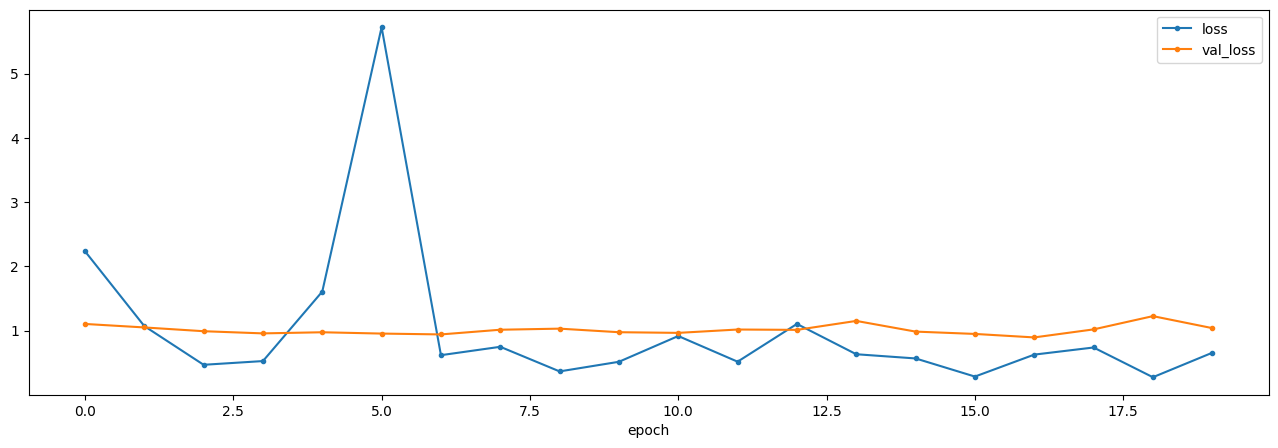

In [15]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [16]:
model.export_TF(
    #name='Noise2Void - 3P ubiTom', 
    name='Noise2Void - 3P XCR1', 
    description='!TEST! 3P ubiTom from 3D stack', 
    authors=["Dominik Schienstock"],
    test_img=X_val[0,...], axes='ZYXC',
    patch_shape=patch_shape,
    result_path=basedir)

1/1 [==============================] - 0s 359ms/step
INFO:tensorflow:Assets written to: /Users/Dominik/Downloads/n2v/tf_model/assets


INFO:tensorflow:Assets written to: /Users/Dominik/Downloads/n2v/tf_model/assets
/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/f0/6j2646qj5m72t_rv2g9901jc0000gn/T/Dominik/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/f0/6j2646qj5m72t_rv2g9901jc0000gn/T/Dominik/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"foun


Model exported in BioImage ModelZoo format:
/Users/Dominik/Downloads/n2v/n2v.bioimage.io.zip


/Users/Dominik/Library/r-miniconda/envs/r-cecelia-env/lib/python3.9/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'modality': ['electron-microscopy', 'cryo-electron-microscopy', 'fluorescence-light-microscopy', 'transmission-light-microscopy', 'super-resolution-microscopy', 'x-ray-microscopy', 'force-microscopy', 'high-content-imaging', 'whole-slide-imaging', 'other']}, {'content': ['cells', 'nuclei', 'extracellular-vesicles', 'tissue', 'plant', 'mitochondria', 'vasculature', 'cell-membrane', 'brain', 'whole-organism']}, {'method': ['stardist', 'cellpose', 'yolo', 'care', 'n2v', 'denoiseg']}]
  warnings.warn(msg, category=ValidationWarning)
